# Set Up
## Import

In [1]:
import numpy as np
from numba import jit, prange, njit, vectorize
import pandas
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time

## Settings

In [8]:
#CAUTION: if R is chosen too small and N too high, then when the program will try to calculate the inverse of dGr
# in the calculation of the saturated density profile, the following error will show: 'Matrix singular to numerical precision.'
# for example, for R=0.75, N=1000 is too high.  
R=0.75#cm
H=0.2 #cm
N=500
M=200
position_of_electrons=100

hr=R/N
hz=H/M

e=4.80324e-10

N_Vib=np.round(0.4/hr)
N_Vmb=np.round(0.57/hr)
N_Vob = np.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)

eps=1e-10
GreenFuncName = f"GreenFunction/Green_njit_R{str(R).replace('.', 'pt')}_H{str(H).replace('.', 'pt')}_N{N}_M{M}_posiE{position_of_electrons}_epsE{int(np.log10(eps))}.npy" 
header = "R"+str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps))

# Define Functions

In [15]:
iRange = np.arange(2, N+1)

@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = np.full((M+1,N+1),-1/300)
fitil = np.full((M+1,N+1),-1/300)
aStart = np.zeros((M-1, N+1))
a = np.zeros((M-1, N+1))

def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    
    
    np.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    #err = np.zeros((M+1, N+1))
    
    count = 0
    errHere = 1e-8
    print(count)
    np.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        np.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)

        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(np.abs(fitil[1:M, 0:N+1] - a))

    return fitil

In [16]:
preCalcDisStat = np.arange(1, N+1)

@jit(nopython = True, fastmath=True, parallel=True)
def distribSTATIC(R,H,N,M,G,Ertil,dGr,radius_of_electron_pool):

    dens = np.zeros(N+1)
    dens[:int(radius_of_electron_pool)+1] = np.dot(Ertil[:int(radius_of_electron_pool)+1], np.linalg.inv(dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]))

    A = np.zeros(N+1)

    A[0] = np.pi * np.power((hr/2), 2)
    A[N] = np.pi *(N - 5/4) * np.power(hr, 2)
    A[0:N] = 2 * np.pi * (preCalcDisStat - 1) * np.power(hr, 2)
    
    temp = A[0:len(dens)] * dens[0:len(dens)]
    
    N_total = np.sum(temp)
    
    return dens, N_total, A, temp

# Calculations

## Load Green Function

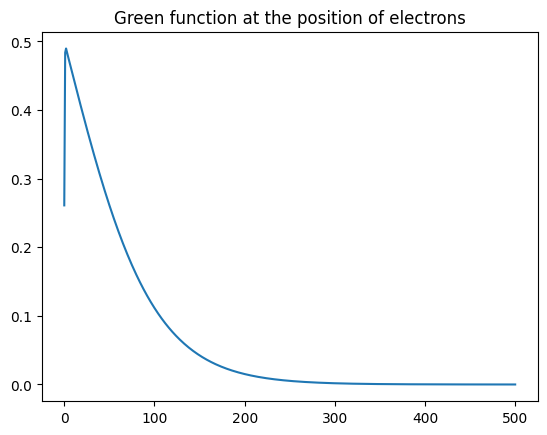

In [17]:
# # ------------ Load Green Function  ------------ #
G = np.load(GreenFuncName)

# here you can compare G with another Green function
plt.plot(G[position_of_electrons,0,:])
plt.title('Green function at the position of electrons')
plt.show()

In [18]:
dGr = np.zeros((N, N))
dGzTOP = np.zeros((N, N))
dGzBOTTOM = np.zeros((N, N))

# # ----------- Green function difference along the charge pool ----------- #
for n in range(0, N):
    for i in range(0, N):
        dGr[n,i] = -4*np.pi*e*(G[position_of_electrons,i+1,n]-G[position_of_electrons,i,n])
    
# # ----------- Green function difference across the cell's top ----------- #
        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz) #for testing
        

# # ----------- Green function difference across the cell's bottom ----------- #
        dGzBOTTOM[n,i] = -4 * np.pi * e * (G[1,i,n]-G[0,i,n])*(hr/hz)

## Choose the voltage sweep

In [19]:
Eztil = np.zeros(N+1)

Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Vit=0/300 #statvolt
Vmt=0/300 #statvolt
Vot=0/300 #statvolt

Vr=0/300 #statvolt

# Vmb =15/300
Vib = 17/300
Vmb=17/300

# Vob = cp.arange(-96, -5.5, 0.5)/300
Vob_start=0
Vob_stop=-160
Vob_step=-0.3

Vob = np.arange(Vob_start, Vob_stop, Vob_step)/300


## Calculate $\tilde \Phi$ (if it is already calculated, do not run this code)

In [20]:
def phitilGen():

    phitilInitial = fitilSOLUT(R,H,N,M,Vib,Vmb,Vob[0],N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr)

    phitilList = np.array(np.zeros((len(Vob), np.shape(phitilInitial)[0], np.shape(phitilInitial)[1])))

    phitilList[0] = phitilInitial
    

    for i in range(1, len(Vob)):
        print(len(Vob) - i)
        phitilList[i] = fitilSOLUT(R,H,N,M,Vib,Vmb,Vob[i],N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt,N_Vot, N_Vob, Vr)
        

    return phitilList

phitilList = phitilGen()


0
1.513985603586454e-06
6.241325619486815e-07
2.6550944776798646e-07
1.1276838183388316e-07
4.772751497836292e-08
2.011516097785715e-08
533
0
1.5139856032256316e-06
6.241323962617729e-07
2.655077718863308e-07
1.1276353536343597e-07
4.772119420112797e-08
2.0109655957806227e-08
532
0
1.5139856028544008e-06
6.24132230557517e-07
2.655060959873279e-07
1.1275868889645824e-07
4.7714873434301364e-08
2.010415096551088e-08
531
0
1.5139856024901088e-06
6.241320648775472e-07
2.655044201056722e-07
1.1275384242601105e-07
4.7708552660535863e-08
2.00986459558683e-08
530
0
1.5139856021223475e-06
6.241318991802303e-07
2.655027442136082e-07
1.1274899595556387e-07
4.770223189023981e-08
2.009314093234793e-08
529
0
1.5139856017441777e-06
6.241317334933216e-07
2.6550106833195253e-07
1.1274414948164724e-07
4.7695911123413204e-08
2.0087635929644243e-08
528
0
1.5139856013833553e-06
6.241315678029435e-07
2.654993924329496e-07
1.1273930300773061e-07
4.7689590349647704e-08
2.0082130916532215e-08
527
0
1.5139856010

2.6541224630929894e-07
1.124872865340687e-07
4.736140718844539e-08
1.9795870314504027e-08
475
0
1.5139855818954717e-06
6.2412406054424e-07
2.654105704241738e-07
1.1248244005668262e-07
4.7355098956730624e-08
1.979036531180034e-08
474
0
1.513985581524241e-06
6.241239285872946e-07
2.6540889452864036e-07
1.1247759358970488e-07
4.7348790725015855e-08
1.978486029868831e-08
473
0
1.5139855811564795e-06
6.241237966338187e-07
2.654072186400458e-07
1.1247274712619659e-07
4.734248250023998e-08
1.977935528904573e-08
472
0
1.5139855807887181e-06
6.241236718343424e-07
2.654055427479818e-07
1.1246790065574941e-07
4.733617426852521e-08
1.977385028981149e-08
471
0
1.5139855804174873e-06
6.24123548804284e-07
2.6540386687673445e-07
1.1246305417836333e-07
4.73298660264021e-08
1.9768345269760568e-08
470
0
1.5139855800566648e-06
6.241234257603478e-07
2.65402190981201e-07
1.124582077044467e-07
4.732355781203457e-08
1.9762840249709646e-08
469
0
1.5139855796784951e-06
6.241233027129423e-07
2.654005150995453e-0

KeyboardInterrupt: 

### Save PhiTilList

In [18]:
PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps)) + '_Vob_step='+ str(Vob_step).replace('.','pt')+ '_Vob_start=' +str(Vob_start).replace('.','pt') +'_Vob_stop='+ str(Vob_stop).replace('.','pt') + '.npy'
fileName = "VobSweep/Vib17V_Vmb17V/" + str(PhiTilName)

phitilNump = np.asnumpy(phitilList)
np.save(fileName, phitilNump)

Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

print(fileName)

## Load PhiTilList if already calculated

In [24]:
PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps)) + '_Vob_step='+ str(Vob_step).replace('.','pt')+ '_Vob_start=' +str(Vob_start).replace('.','pt') +'_Vob_stop='+ str(Vob_stop).replace('.','pt') + '.npy'
fileName = "VobSweep/Vib17V_Vmb17V/" + str(PhiTilName)

phitilNump_loaded = np.load(fileName)

print(PhiTilName)
phitilNump=np.load(fileName)
print(np.shape(phitilNump))

Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)


Phi_R0pt75_H0pt2_N500_M200_posiE100_epsE-10.0_Vob_step=-0pt3_Vob_start=0_Vob_stop=-160.npy
(534, 201, 501)


## Saturated density profile

In [25]:
print(phitilNump.shape)
print(len(Vob))


(534, 201, 501)
534


534
Iterations Left: 535
Iterations Left: 534
Iterations Left: 533
Iterations Left: 532
Iterations Left: 531
Iterations Left: 530
Iterations Left: 529
Iterations Left: 528
Iterations Left: 527
Iterations Left: 526
Iterations Left: 525
Iterations Left: 524
Iterations Left: 523
Iterations Left: 522
Iterations Left: 521
Iterations Left: 520
Iterations Left: 519
Iterations Left: 518
Iterations Left: 517
Iterations Left: 516
Iterations Left: 515
Iterations Left: 514
Iterations Left: 513
Iterations Left: 512
Iterations Left: 511
Iterations Left: 510
Iterations Left: 509
Iterations Left: 508
Iterations Left: 507
Iterations Left: 506
Iterations Left: 505
Iterations Left: 504
Iterations Left: 503
Iterations Left: 502
Iterations Left: 501
Iterations Left: 500
Iterations Left: 499
Iterations Left: 498
Iterations Left: 497
Iterations Left: 496
Iterations Left: 495
Iterations Left: 494
Iterations Left: 493
Iterations Left: 492
Iterations Left: 491
Iterations Left: 490
Iterations Left: 489
Iteration

Iterations Left: 145
Iterations Left: 144
Iterations Left: 143
Iterations Left: 142
Iterations Left: 141
Iterations Left: 140
Iterations Left: 139
Iterations Left: 138
Iterations Left: 137
Iterations Left: 136
Iterations Left: 135
Iterations Left: 134
Iterations Left: 133
Iterations Left: 132
Iterations Left: 131
Iterations Left: 130
Iterations Left: 129
Iterations Left: 128
Iterations Left: 127
Iterations Left: 126
Iterations Left: 125
Iterations Left: 124
Iterations Left: 123
Iterations Left: 122
Iterations Left: 121
Iterations Left: 120
Iterations Left: 119
Iterations Left: 118
Iterations Left: 117
Iterations Left: 116
Iterations Left: 115
Iterations Left: 114
Iterations Left: 113
Iterations Left: 112
Iterations Left: 111
Iterations Left: 110
Iterations Left: 109
Iterations Left: 108
Iterations Left: 107
Iterations Left: 106
Iterations Left: 105
Iterations Left: 104
Iterations Left: 103
Iterations Left: 102
Iterations Left: 101
Iterations Left: 100
Iterations Left: 99
Iterations Lef

-0.532
-0.533


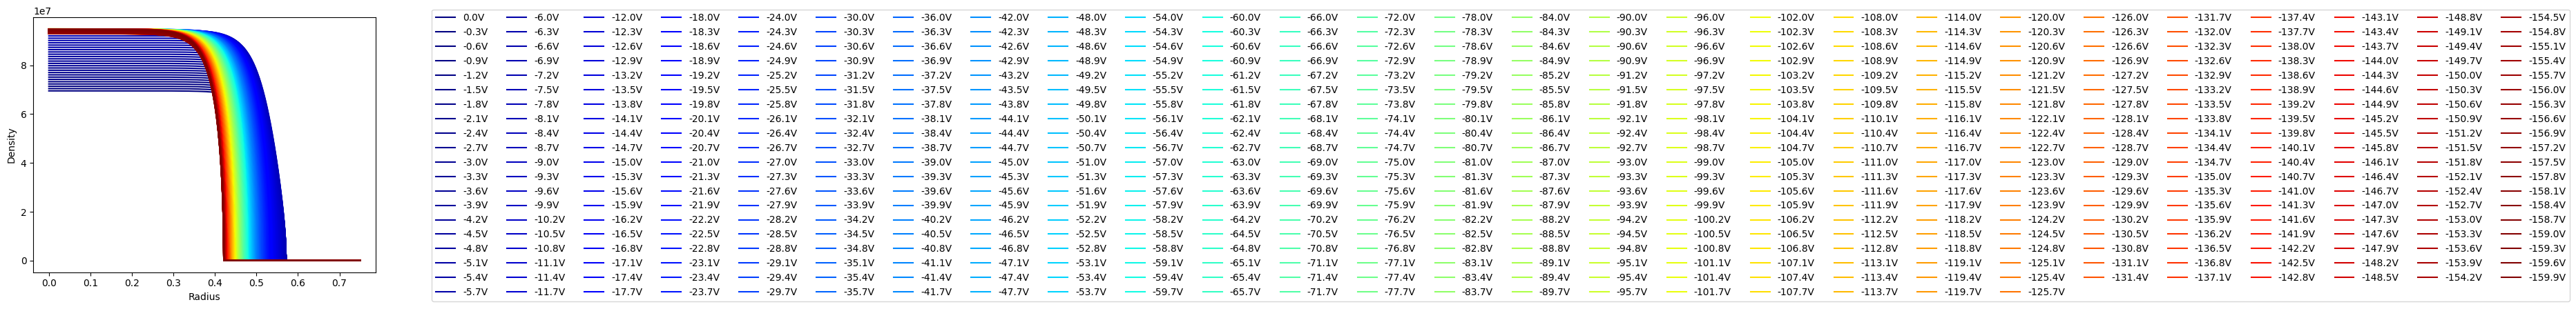

In [26]:
#for each potential, calculates the density profile (depeding on the radus of the electron pool)
Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)
print(len(phitilNump))

N_total_list = np.zeros(len(phitilNump))
N_per_ring_list = np.zeros((len(phitilNump), N+1))
denList = np.zeros((len(phitilNump), N+1))
density_max_list = np.zeros(len(phitilNump))
R_star_list = np.zeros(len(phitilNump))
for l in range(0, len(phitilNump)):

    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]

        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz

    
    


    radius_of_electron_pool = np.round(0.57/hr)
    

    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])

    
    for k in range(0, len(radius_of_electron_pool_list)):

        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        

        # ------------- induced charge at the top inner electrode ------------------- #
        Ez = EztilTOP[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind=Qsum/e

        # ------------- induced charge at the bottom inner electrode ------------------- #
        Ez = EztilBOTTOM[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind = Qsum/e

        # ------------  potential at/below/above the electrons ------------ #


        copyAr2D(G_at_electrons, G[position_of_electrons].T)
        copyAr2D(G_below_electrons, G[position_of_electrons-1].T)
        copyAr2D(G_above_electrons, G[position_of_electrons+1].T)
        
        phi_at_electrons = phitil[position_of_electrons] - 4 * np.pi * e * hr * np.dot(density, G_at_electrons)
        phi_below_electrons = phitil[position_of_electrons-1] - 4 * np.pi * e * hr * np.dot(density, G_below_electrons)
        phi_above_electrons = phitil[position_of_electrons+1] - 4 * np.pi * e * hr * np.dot(density, G_above_electrons)

        # ---------- electric r-field across the liquid surface  ---------- #
        Er = np.zeros(N)

        Er[0:N] = (phi_at_electrons[0:N] - phi_at_electrons[1:N+1])/hr
        
        # ------------ electric field acting on electrons  ---------------- #
        Ezbelow[0:N+1] = (phi_below_electrons[0:N+1] - phi_at_electrons[0:N+1])/hz
        Ezabove[0:N+1] = (phi_at_electrons[0:N+1] - phi_above_electrons[0:N+1])/hz
        
        # adds the electric field acting on the electrons at the center to a list 
        Ezuplist[k] = Ezabove[0]
    
    
    minimum = np.amin(np.abs(Ezuplist))
    # chooses the index of the smallest absolute value of the electric field acting on the electrons at the center
    idx = np.argmin(np.abs(Ezuplist))

    # chooses the radius of the electron pool accordingly
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    #calculates the final density profile with the chosen radius of the electron pool
    # this is done for every potential in the Vob sweep
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
    
    
    N_total_list[l] = N_total
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    N_per_ring_list[l] = N_per_ring

colors = plt.cm.jet(np.linspace(0,1,len(denList)))

for d in range(0, len(denList)):
    print(Vob[d])
    plt.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(np.round(Vob[d] * 300,1))+'V')


plt.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
plt.ylabel("Density")
plt.xlabel("Radius")
plt.show()



### Run if you want to save the saturated densities

In [27]:
for idx in range(len(denList)):
    Vob_str = f"{Vob[idx] * 300:.1f}".replace(".", "p")
    filename = f"VobSweep/Vib17V_Vmb17V/saturated_density_backup/saturated_density_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(filename, data_to_save)

#filename
data_to_save

array([[0.00000000e+00, 1.50000000e-03, 3.00000000e-03, ...,
        7.47000000e-01, 7.48500000e-01, 7.50000000e-01],
       [9.46991192e+07, 9.46991353e+07, 9.46991283e+07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

## Fixed N Density List

In [28]:
Percentage=100
Percentage

100

Iterations Left: 535
380.0
0.0
Iterations Left: 534
380.0
-0.0010167870124307727
Iterations Left: 533
380.0
-0.002422185634083687
Iterations Left: 532
380.0
-0.004219732281524077
Iterations Left: 531
380.0
-0.006411623116621834
Iterations Left: 530
380.0
0.006267840857352973
Iterations Left: 529
380.0
0.003531584114058915
Iterations Left: 528
380.0
0.00039643540239727825
Iterations Left: 527
380.0
-0.003135685041173217
Iterations Left: 526
380.0
-0.007061661002345154
Iterations Left: 525
380.0
0.0049979695564883455
Iterations Left: 524
380.0
0.0005186742848547839
Iterations Left: 523
380.0
-0.004347805818756336
Iterations Left: 522
380.0
0.007381409273678532
Iterations Left: 521
380.0
0.001965048963160147
Iterations Left: 520
380.0
-0.0038265875433794424
Iterations Left: 519
380.0
0.007561478689658002
Iterations Left: 518
380.0
0.0012294668082698048
Iterations Left: 517
380.0
-0.005461211933697134
Iterations Left: 516
380.0
0.005577123629060177
Iterations Left: 515
380.0
-0.00163895570

0.0037107823080773173
Iterations Left: 366
380.0
0.007951941843687112
Iterations Left: 365
380.0
0.012193101959145133
Iterations Left: 364
380.0
-0.01015727972386504
Iterations Left: 363
380.0
-0.006026640377697455
Iterations Left: 362
380.0
-0.0018960004431759932
Iterations Left: 361
380.0
0.0022346388599501017
Iterations Left: 360
380.0
0.006365278759139766
Iterations Left: 359
380.0
0.01049591801889451
Iterations Left: 358
380.0
-0.012017873069395538
Iterations Left: 357
380.0
-0.00799531195187037
Iterations Left: 356
380.0
-0.003972749019919952
Iterations Left: 355
380.0
4.9813256855700425e-05
Iterations Left: 354
380.0
0.00407237615002674
Iterations Left: 353
380.0
0.008094937174219129
Iterations Left: 352
380.0
0.012117499378463842
Iterations Left: 351
380.0
-0.010641009882562684
Iterations Left: 350
380.0
-0.00672410908045724
Iterations Left: 349
380.0
-0.0028072064491050696
Iterations Left: 348
380.0
0.0011096954988163515
Iterations Left: 347
380.0
0.005026596223179055
Iteratio

-0.0034070816392231013
Iterations Left: 197
380.0
-0.000948324436049529
Iterations Left: 196
380.0
0.00151043126817099
Iterations Left: 195
380.0
0.0039691857129814335
Iterations Left: 194
380.0
0.006427942613853189
Iterations Left: 193
380.0
0.008886697994452753
Iterations Left: 192
380.0
0.01134545211108004
Iterations Left: 191
380.0
0.013804208706293732
Iterations Left: 190
380.0
-0.011844165107528644
Iterations Left: 189
380.0
-0.009453356310822947
Iterations Left: 188
380.0
-0.00706254763009635
Iterations Left: 187
380.0
-0.004671737911217167
Iterations Left: 186
380.0
-0.0022809294624852113
Iterations Left: 185
380.0
0.00010988149844538439
Iterations Left: 184
380.0
0.002500689720495604
Iterations Left: 183
380.0
0.004891497824417745
Iterations Left: 182
380.0
0.007282306970440205
Iterations Left: 181
380.0
0.009673114838066058
Iterations Left: 180
380.0
0.012063922586239147
Iterations Left: 179
380.0
-0.013657649661311465
Iterations Left: 178
380.0
-0.011333043758100474
Iteratio

0.006918508717499658
Iterations Left: 27
380.0
0.008669124957658907
Iterations Left: 26
380.0
0.010419739422201816
Iterations Left: 25
380.0
0.012170350845596232
Iterations Left: 24
380.0
0.013920964426532111
Iterations Left: 23
380.0
-0.013001906060492632
Iterations Left: 22
380.0
-0.011300697280373272
Iterations Left: 21
380.0
-0.00959949019493548
Iterations Left: 20
380.0
-0.00789827969847162
Iterations Left: 19
380.0
-0.006197073438329543
Iterations Left: 18
380.0
-0.004495867582368081
Iterations Left: 17
380.0
-0.002794662129394134
Iterations Left: 16
380.0
-0.001093457078210084
Iterations Left: 15
380.0
0.0006077475723805013
Iterations Left: 14
380.0
0.0023089518235645252
Iterations Left: 13
380.0
0.0040101519508836175
Iterations Left: 12
380.0
0.005711355419820563
Iterations Left: 11
380.0
0.00741255730032069
Iterations Left: 10
380.0
0.009113756298771869
Iterations Left: 9
380.0
0.010814958604114883
Iterations Left: 8
380.0
0.012516155684421581
Iterations Left: 7
380.0
0.014217

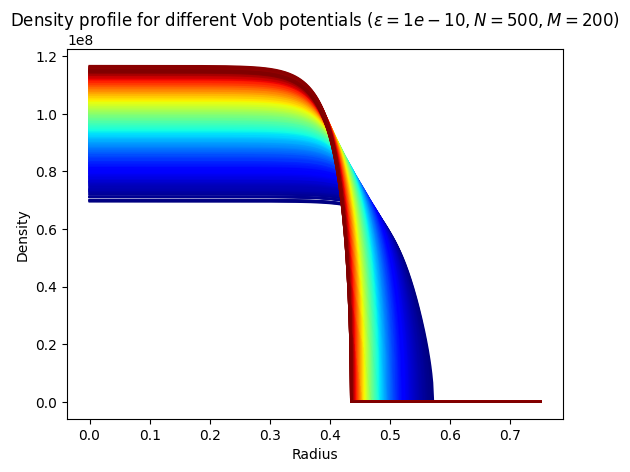

In [29]:
Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)

N_Fixed_list = np.copy(N_total_list)

# fix the number of electrons to be equal to the number of electrons at Vob=-96V 
# indeed the sweep of Vob is done from -96V to -5.5V, so the number of electrons at Vob=-96V is the one that is fixed



N_Fixed = Percentage*N_total_list[0]/100

for l in range(0, len(phitilNump)):

    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]



        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz

    
    radius_of_electron_pool = np.round(0.57/hr)
    print(radius_of_electron_pool)
    
    #radius_of_electron_pool_list = np.arange(radius_of_electron_pool - 350,radius_of_electron_pool+1)
    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])


    N_total_vect = np.zeros(len(radius_of_electron_pool_list))
    for k in range(0, len(radius_of_electron_pool_list)):
        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        N_total_vect[k] = N_total
    minimum = np.amin(np.abs(N_total_vect - N_Fixed))
    idx = np.argmin(np.abs(N_total_vect - N_Fixed))

    
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)

    
    N_total_list[l] = N_total
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    print((N_total-N_Fixed)/N_Fixed)
    
colors = plt.cm.jet(np.linspace(0,1,len(denList)))

for d in range(0, len(denList)):
    plt.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(Vob[d] * 300)+'V')

plt.ylabel("Density")
plt.xlabel("Radius")
# plt.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
plt.title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')
plt.show()


plt.show()

In [30]:
#the file DensityFiles/EPS{int(np.log10(eps))} needs to be created before running the code
for idx in range(len(denList)):
    Vob_str = f"{Vob[idx] * 300:.1f}".replace(".", "p")
    filename = f"VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_{int(Percentage)}_percent_SatENum/" \
           f"FixedN_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    # filename = f"DensityFiles/EPS{int(np.log10(eps))}/FixedN_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    print(filename)
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(filename, data_to_save)



VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob0p0_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-0p3_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-0p6_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-0p9_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-1p2_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-1p5_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-1p8_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-2p1_N500_M200_posiE100.npy
VobSweep/Vib17V_V

VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-122p4_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-122p7_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-123p0_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-123p3_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-123p6_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-123p9_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-124p2_N500_M200_posiE100.npy
VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_100_percent_SatENum/FixedN_Vib17_Vmb17_Vob-124p5_N500_M200_posiE100.npy
